In [ ]:
!pip install tensorflow matplotlib numpy


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
from google.colab import files
from IPython.display import Image

In [19]:
uploaded = files.upload()

Saving 1.jpg to 1 (1).jpg
Saving 2.jpg to 2 (1).jpg


In [ ]:
def load_and_process_image(path):
    img = load_img(path, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return vgg19.preprocess_input(img)

content_image = load_and_process_image("1.jpg")
style_image = load_and_process_image("2.jpg")


In [ ]:
model = vgg19.VGG19(weights='imagenet', include_top=False)
model.trainable = False


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
content_layer = 'block5_conv2'
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]


In [ ]:
outputs = [model.get_layer(name).output for name in style_layers]
outputs.append(model.get_layer(content_layer).output)

feature_extractor = tf.keras.Model(model.input, outputs)


In [ ]:
def gram_matrix(tensor):
    channels = tensor.shape[-1]
    x = tf.reshape(tensor, [-1, channels])
    return tf.matmul(x, x, transpose_a=True)


In [ ]:
def style_loss(style, generated):
    return tf.reduce_mean(tf.square(gram_matrix(style) - gram_matrix(generated)))

def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))


In [ ]:
generated_image = tf.Variable(content_image, dtype=tf.float32)
optimizer = tf.optimizers.Adam(learning_rate=0.02)

style_features = feature_extractor(style_image)[:-1]
content_feature = feature_extractor(content_image)[-1]

for i in range(300):
    with tf.GradientTape() as tape:
        outputs = feature_extractor(generated_image)
        style_output = outputs[:-1]
        content_output = outputs[-1]

        s_loss = sum(style_loss(style_features[j], style_output[j]) for j in range(len(style_layers)))
        c_loss = content_loss(content_feature, content_output)

        total_loss = s_loss + c_loss

    grads = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(grads, generated_image)])

    if i % 50 == 0:
        print(f"Step {i} | Loss: {total_loss.numpy()}")


Step 0 | Loss: 9.662771036894003e+16
Step 50 | Loss: 8.290409585731174e+16
Step 100 | Loss: 7.27098277714985e+16
Step 150 | Loss: 6.409267167677645e+16
Step 200 | Loss: 5.65763157000192e+16
Step 250 | Loss: 4.993700493000704e+16


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

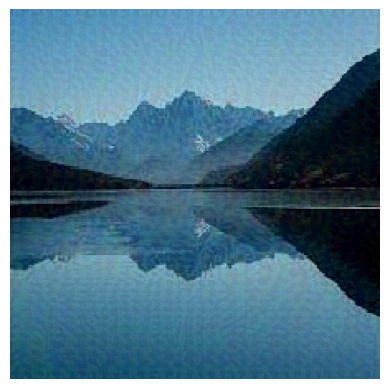

In [ ]:
def deprocess_image(img):
    img = img[0]
    img = img + [103.939, 116.779, 123.68]
    img = img[:, :, ::-1]
    return np.clip(img / 255, 0, 1)

plt.imshow(deprocess_image(generated_image.numpy()))
plt.axis('off')
